# Retrieving winds from the vorticity and divergence fields

Deep learning is often used to extract features from the data. In geosciences its increasingly used in the parameterization of unresolved sub-grid dynamics. Few examples include the convection parameterization in general circulation model [(Gentine et al., 2018)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018GL078202), ocean data inference [(Bolton and Zanna, 2019)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018MS001472), radiative transfer calculations [(Pal et al., 2019)]( https://doi.org/10.1029/2018GL081646), rainfall prediction [(Miao et al., 2015)](https://doi.org/10.1175/JHM-D-14-0174.1), flux estimation [(Jung et al., 2011)](https://doi.org/10.1029/2010JG001566).
The idea is to allow the machine learning algorithm to learn directly from the data without the need for explicit formulation. These models tend to be computationally efficient and often more accurate than the traditional methods. 



In this notebook we try to retrieve the wind fields from the vorticity and divergence fields. Though its not exactly a parameterization problem but the idea is similar. We use deep learning to learn a function which maps the vorticty and divergence to the wind fields, but without using the spherical transforms. 
2.5$^{\circ}$ X 2.5$^{\circ}$, 6-hourly ERA-Interim data from 1979-2018 (40 years) is used. Vorticity and divergence fields are used as input and zonal and meridional winds are the targets. All the fields are at 500 hpa level. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import keras
import xarray
plt.ion()
seaborn.set_style('whitegrid',rc={"axes.edgecolor":'black'})

Using TensorFlow backend.


In [2]:
data = xarray.open_dataset('Data/era_winds.nc')
vrt  = data['vo']
div  = data['d']
u    = data['u']
v    = data['v']
lats = data['latitude']
lons = data['longitude']
data.close()

First 50,000 samples are used for training and the remaining 8440 samples for testing. Sanples are randomly shuffled in each of these sets. Cross-validation is used to evaluate different models.
The inputs and outputs are normalized by its training  mean and variance, so that they have similar scales. This often helps in speeding up the training.

In [3]:
#Normalization
def normData(var, idx):
    varMean = np.mean(var[0:idx])
    varStd  = np.std(var[0:idx])
    varNorm = (var - varMean) / varStd
    return varNorm, varMean.values, varStd.values
    

vrtNorm, vrtMean, vrtStd = normData(vrt, 50000)
divNorm, divMean, divStd = normData(div, 50000)
uNorm, uMean, uStd = normData(u, 50000)
vNorm, vMean, vStd = normData(v, 50000)

In [4]:
# creating train and test sets 
np.random.seed(23)

ntotal = len(vrt)
ntrain = 50000
ntest  = ntotal - ntrain 

trainIdx = np.random.permutation(ntrain)
testIdx  = np.random.permutation(ntest) + ntrain 

X = np.stack((vrtNorm,divNorm),axis=3)
X_train = X[trainIdx]
X_test  = X[testIdx]
u_train = uNorm[trainIdx]
u_test  = uNorm[testIdx]
v_train = vNorm[trainIdx]
v_test  = vNorm[testIdx]

print ("X_train shape:", X_train.shape)
print ("X_test shape:", X_test.shape)

X_train shape: (50000, 73, 144, 2)
X_test shape: (8440, 73, 144, 2)


The model has 2 inputs (vorticity and divergence) and 2 outputs (zonal and meridional wind).
Six layer deep, fully connected network is used. First 3 layers are shared between the two outputs. It also has another 3 layers for each of the outputs which is not shared. Each layer has 512 units wuth ReLU activation, except the last one. The last layer has 10512 units (with no activation) which is then reshaped to the output image of size 73 X 144. Adam optimization is used with mean squared loss. No regularization was used as the model was not overfitting. Model summary is printed below along with the block diagram.


In [5]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Reshape, Flatten
from keras.optimizers import Adam

# model = Sequential()
inputs = Input(shape=(X.shape[1],X.shape[2],X.shape[3]), name='inputs')
flat   = Flatten(name='flat')(inputs)


dense1 = Dense(512, activation = 'relu', name='dense1')(flat)
dense2 = Dense(512, activation = 'relu', name='dense2')(dense1)
dense3 = Dense(512, activation = 'relu', name='dense3')(dense2)

denseU1 = Dense(512, activation = 'relu', name='denseU1')(dense3)
denseU2 = Dense(512, activation = 'relu', name='denseU2')(denseU1)
denseU3 = Dense(10512, name='denseU3')(denseU2)
outU    = Reshape((73, 144), name='U')(denseU3)

denseV1 = Dense(512, activation = 'relu', name='denseV1')(dense3)
denseV2 = Dense(512, activation = 'relu', name='denseV2')(denseV1)
denseV3 = Dense(10512, name='denseV3')(denseV2)
outV    = Reshape((73, 144), name='V')(denseV3)

model = Model(inputs, [outU, outV])
model.summary()

model.compile(optimizer=Adam(),
              loss='mse')

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 73, 144, 2)   0                                            
__________________________________________________________________________________________________
flat (Flatten)                  (None, 21024)        0           inputs[0][0]                     
__________________________________________________________________________________________________
dense1 (Dense)                  (None, 512)          10764800    flat[0][0]                       
__________________________________________________________________________________________________
dense2 (Dense)                  (None, 512)          262656      dense1[0][0]                     
_____________________________________

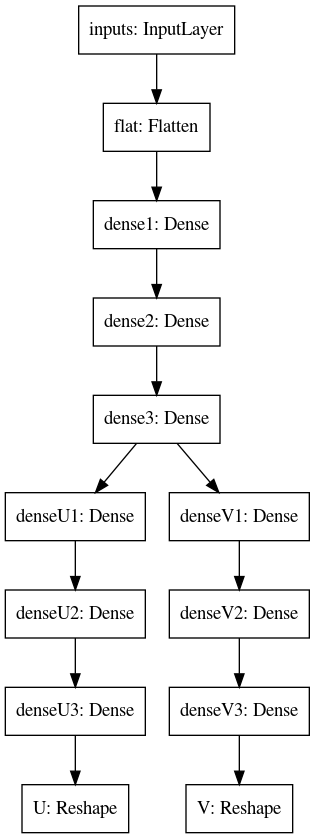

In [6]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')


Model is trained for 10 epochs with a batch size of 128 samples. 20% of training data is used for validation.

In [7]:
history = model.fit(X_train, [u_train, v_train], epochs=10, batch_size=128, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 103s 3ms/step - loss: 1.0657 - U_loss: 0.4182 - V_loss: 0.6476 - val_loss: 0.7645 - val_U_loss: 0.3042 - val_V_loss: 0.4604
Epoch 2/10
40000/40000 [==============================] - 101s 3ms/step - loss: 0.6674 - U_loss: 0.2588 - V_loss: 0.4086 - val_loss: 0.6036 - val_U_loss: 0.2305 - val_V_loss: 0.3731
Epoch 3/10
40000/40000 [==============================] - 101s 3ms/step - loss: 0.5559 - U_loss: 0.2138 - V_loss: 0.3421 - val_loss: 0.5316 - val_U_loss: 0.2067 - val_V_loss: 0.3250
Epoch 4/10
40000/40000 [==============================] - 102s 3ms/step - loss: 0.5096 - U_loss: 0.1955 - V_loss: 0.3141 - val_loss: 0.5008 - val_U_loss: 0.1939 - val_V_loss: 0.3070
Epoch 5/10
40000/40000 [==============================] - 100s 2ms/step - loss: 0.4800 - U_loss: 0.1848 - V_loss: 0.2952 - val_loss: 0.4760 - val_U_loss: 0.1846 - val_V_loss:

(1, 10)

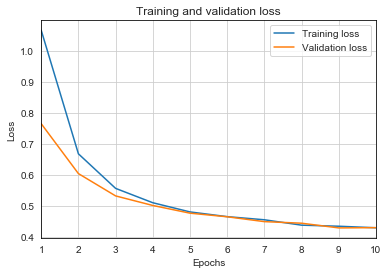

In [8]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xlim(1,len(loss))

Training and validation losses are approaching a steady value around epoch 10. Now we will predict the test output.

In [9]:
up,vp = model.predict(X_test) 

Rescale the normalized outputs to its original values.

In [10]:
u_pred = up * uStd + uMean
v_pred = vp * vStd + vMean
u_true = u_test * uStd + uMean
v_true = v_test * vStd + vMean

In [11]:
from sklearn.metrics import mean_squared_error

u_error = mean_squared_error(np.ravel(u_true), np.ravel(u_pred))
v_error = mean_squared_error(np.ravel(v_true), np.ravel(v_pred))

print ("RMS Error of u wind (in m/s) :", np.sqrt(u_error))
print ("RMS Error of v wind (in m/s) :", np.sqrt(v_error))

RMS Error of u wind (in m/s) : 4.897034
RMS Error of v wind (in m/s) : 4.71643


Comparison of predicted and actual outputs for one time step in the test set.

Text(0.5, 1.0, 'v actual')

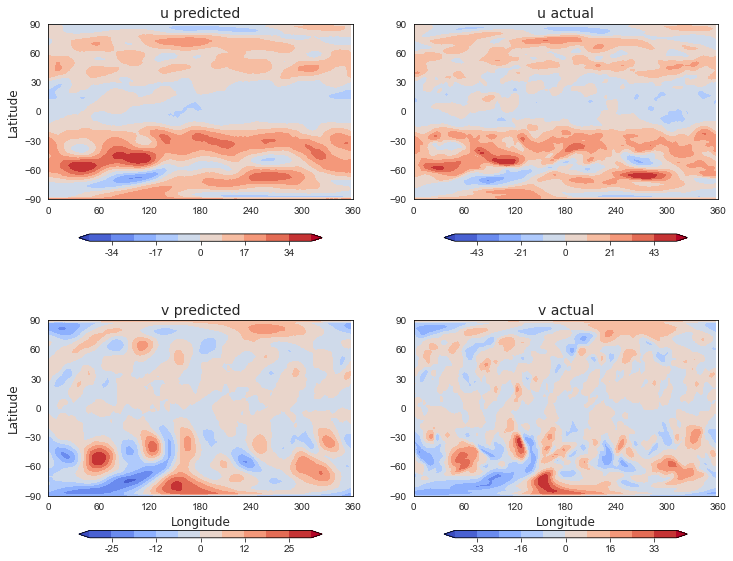

In [12]:
seaborn.set_style('whitegrid',rc={"axes.edgecolor":'black'})
fig,ax = plt.subplots(2,2,figsize=(12,10),squeeze=False)

def plotFig(var,i,j):
    plotLevels = np.linspace(-np.amax(var), np.amax(var),11)
    contours = ax[i,j].contourf(lons,lats,var, levels=plotLevels, cmap='coolwarm', extend='both')
    cb = plt.colorbar(contours,ax=ax[i,j], orientation='horizontal',format='%.0d',shrink=0.8,aspect=30,pad=0.14)
    ax[i,j].grid(alpha=0.7,color='k',linestyle='dotted',dashes=[1,5 ],linewidth=1,zorder=10)
    ax[i,j].set_xticks(np.linspace(0,360,7))
    ax[i,j].set_yticks(np.linspace(-90,90,7))

idx = 1000
plotFig(u_pred[idx],0,0)
plotFig(u_true[idx],0,1)
plotFig(v_pred[idx],1,0)
plotFig(v_true[idx],1,1)

ax[0,0].set_ylabel('Latitude',size='12', fontname = 'Dejavu Sans')
ax[1,0].set_ylabel('Latitude',size='12', fontname = 'Dejavu Sans')  
ax[1,0].set_xlabel('Longitude',size='12', fontname = 'Dejavu Sans')
ax[1,1].set_xlabel('Longitude',size='12', fontname = 'Dejavu Sans')

ax[0,0].set_title('u predicted',size='14', fontname = 'Dejavu Sans')
ax[0,1].set_title('u actual',size='14', fontname = 'Dejavu Sans')
ax[1,0].set_title('v predicted',size='14', fontname = 'Dejavu Sans')
ax[1,1].set_title('v actual',size='14', fontname = 'Dejavu Sans')

Predicted outputs look more or less similar to the actual ones. Its capturing most of the large scale structures though its more smoothened. The predicted values also underestimate the actual magnitudes. Perhaps a higher capacity network would better capture these subtleties. But overall the performace seems to be satisfactory.